Return to Live Ocean Files and see if we can do better

In [60]:
import cmocean.cm as cm
import datetime
import importlib
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as Basemap
import netCDF4 as nc
import numpy as np
import os
import scipy.interpolate as sinter
import xarray as xr

from salishsea_tools import LiveOcean_grid as grid
from salishsea_tools import gsw_calls
from salishsea_tools import LiveOcean_BCs as nancy

%matplotlib inline

In [61]:
importlib.reload(nancy)

<module 'salishsea_tools.LiveOcean_BCs' from '/ocean/sallen/allen/research/Meopar/Tools/SalishSeaTools/salishsea_tools/LiveOcean_BCs.py'>

# Define some stuff

In [62]:
var_meta = {'vosaline': {'grid': 'SalishSea2',
                             'long_name': 'Practical Salinity',
                             'units': 'psu'},
                'votemper': {'grid': 'SalishSea2',
                             'long_name': 'Potential Temperature',
                             'units': 'deg C'}
                }


LO_to_NEMO_var_map = {'salt': 'vosaline',
                          'temp': 'votemper',
                     'NO3': 'NO3'}


    

# Load BC information
 

In [63]:
depBC, lonBC, latBC, shape = nancy.load_SalishSea_boundary_grid(imin=376-1, imax=470, rim=10, 
                                                          meshfilename='/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

# Specify the (New) Boundary Grid

imin = 376 - 1  # want 376  # have 381
imax = 470 # want 470 # have 467
rim = 10 # and remember that NEMO doesn't use the first grid point

with nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as meshfile:


    lonBC = meshfile.variables['nav_lon'][imin:imax, 1:rim+1]
    latBC = meshfile.variables['nav_lat'][imin:imax, 1:rim+1]
    mbathy = meshfile.variables['mbathy'][0, imin:imax, 1:rim+1]
    gdepw = meshfile.variables['gdepw_0'][0, :, imin:imax, 1:rim+1]
    surface_tmask = meshfile.variables['tmask'][0, 0, imin:imax, 1:rim+1]
    tmask = meshfile.variables['tmask'][0, :, imin:imax, 1:rim+1]
    depBC = meshfile.variables['gdept_1d'][0]

surface_tmask = np.abs(surface_tmask - 1)
tmask = tmask -1
shape = lonBC.shape

NEMO_depth = np.zeros(shape)
for i in range(shape[1]):
    for j in range(shape[0]):
        level = mbathy[j, i]
        NEMO_depth[j, i] = gdepw[level, j, i]
NEMO_raw = np.copy(NEMO_depth)
NEMO_depth = np.ma.masked_array(NEMO_depth, mask=surface_tmask)

# Get the Live Ocean File

In [64]:
date = '2017-12-29'
d = nancy.load_LiveOcean(date)

# Process Live Ocean File

## Depth Interpolation

def interpolate_to_NEMO_depths(dataset, depBC,
    var_names = ['salt', 'temp', 'NO3']):

    interps = {}
    for var_name in var_names:
        var_interp = np.zeros(dataset[var_name][0].shape)
        for j in range(var_interp.shape[1]):
            for i in range(var_interp.shape[2]):
                LO_depths = dataset.z_rho.values[0, :, j, i]
                var = dataset[var_name].values[0, :, j, i]
                var_interp[:, j, i] = np.interp(
                    -depBC, LO_depths, var, left=np.nan)
        interps[var_name] = np.ma.masked_invalid(var_interp)
    return interps

In [65]:
interps = nancy.interpolate_to_NEMO_depths(d, depBC)

In [66]:
dataset = d
lonsLO = dataset.lon_rho.values[0, :]
latsLO = dataset.lat_rho.values[:, 0]

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(lonsLO, latsLO, interps['salt'][0], cmap=cm.haline)
ax.pcolormesh(lonBC, latBC, 1-tmask[0], cmap='copper')

## Convert to TEOS-10

In [67]:
var_meta, interps['salt'], interps['temp'] = \
            nancy._convert_TS_to_TEOS10(
                var_meta, interps['salt'], interps['temp'])

## Remove South of Tatoosh

for var in interps.keys():
    print (var)
    for i in range(6):
        for j in range(17):
            interps[var][:, i, j] = np.nan

    interps[var] = np.ma.masked_invalid(interps[var][:])

In [68]:
interps = nancy.remove_south_of_Tatoosh(interps)

fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        axs[j, i].pcolormesh(interps['NO3'][i+j*5], vmax=40, vmin=0)
        axs[j, i].text(20, 23, str(i+j*5))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)

fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        axs[j, i].pcolormesh(interps['temp'][i+j*5], cmap=cm.haline)
        axs[j, i].text(20, 23, str(i+j*5))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)

## Fill

def fill_box(interps, maxk=35):
    for var in interps.keys():
        for k in range(maxk):
            array = np.ma.masked_invalid(interps[var][k])
            xx, yy = np.meshgrid(range(interps[var].shape[2]), 
                                 range(interps[var].shape[1]))
            x1 = xx[~array.mask]
            y1 = yy[~array.mask]
            newarr = array[~array.mask]
            interps[var][k] = sinter.griddata((x1, y1), newarr.ravel(),
                         (xx, yy), method='nearest')
    return interps

In [69]:
interps = nancy.fill_box(interps)

fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        axs[j, i].pcolormesh(interps['salt'][i+j*5], cmap=cm.haline, vmax=34.5, vmin=30)
        axs[j, i].text(20, 23, str(i+j*5))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)

fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        axs[j, i].pcolormesh(interps['temp'][i+j*5], cmap=cm.thermal, vmax=9, vmin=7)
        axs[j, i].text(20, 23, str(i+j*5))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)

## Convect

In [70]:
sigma = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [interps['salt'][:], interps['temp'][:] ])

def convect(sigma, interps, var_names):
    kmax, imax, jmax = sigma.shape
    good = False
    while not good:
        print('Loop')
        good = True
        for k in range(kmax - 1):
            for i in range(imax):
                for j in range(jmax):
                    if sigma[k, i, j] > sigma[k + 1, i, j]:
                        good = False
                        for var in var_names:
                            interps[var][k, i, j], interps[var][
                                k + 1, i, j] = interps[var][
                                    k + 1, i, j], interps[var][k, i, j]
                        sigma[k, i, j], sigma[k + 1, i, j] = sigma[
                            k + 1, i, j], sigma[k, i, j]
    return sigma, interps

In [71]:
sigma, interps = nancy.convect(sigma, interps)

columns = 7
rows = 5
fig, axs = plt.subplots(rows, columns, figsize=(20, 20))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(interps['salt'][i+j*columns], cmap='plasma', vmax=34.5, vmin=30)
        axs[j, i].text(20, 23, str(i+j*columns))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)
print(np.mean(interps['salt'][0]))
print(np.mean(interps['salt'][15]))
print(np.mean(interps['salt'][30]))


columns = 7
rows = 5
fig, axs = plt.subplots(rows, columns, figsize=(20, 20))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(interps['temp'][i+j*columns], cmap=cm.thermal, vmax=9, vmin=7)
        axs[j, i].text(20, 23, str(i+j*columns))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)
print(np.mean(interps['temp'][0]))
print(np.mean(interps['temp'][15]))
print(np.mean(interps['temp'][30]))

fig, ax = plt.subplots(1, 1)
mesh = ax.pcolormesh(sigma[:-1, :, 5] - sigma[1:, :, 5], vmin=-2, vmax=2, cmap='bwr')
fig.colorbar(mesh)
ax.invert_yaxis()
print(np.nanmax(sigma[:-1, :, :] - sigma[1:, :, :]))

## Extend to Depth

var_names = interps.keys()
for var in var_names:
    interps[var][35:] = interps[var][34]

In [72]:
interps = nancy.extend_to_depth(interps)

## Interpolate Horizontally onto NEMO grid

In [73]:
def interpolate_to_NEMO_lateral(interps, dataset, NEMOlon, NEMOlat, shape):
    interpl = {}
    lonsLO = dataset.lon_rho.values[0, :]
    latsLO = dataset.lat_rho.values[:, 0]
    for var in interps.keys():
        var_new = np.zeros((interps[var].shape[0], shape[0], shape[1]))
        for k in range(var_new.shape[0]):
            var_grid = interps[var][k, :, :]
            var_new[k, ...] = Basemap.interp(
                var_grid, lonsLO, latsLO, NEMOlon, NEMOlat)
        interpl[var] = var_new
    return interpl

In [74]:
interpl = nancy.interpolate_to_NEMO_lateral(interps, d, lonBC, latBC, shape)

## Convect Again

In [75]:
sigmal = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [interpl['salt'][:], interpl['temp'][:] ])

In [76]:
print(np.nanmax(sigmal[:-1, :, :] - sigmal[1:, :, :]))
sigmal, interpl = nancy.convect(sigmal, interpl)
print(np.nanmax(sigmal[:-1, :, :] - sigmal[1:, :, :]))

0.001
0.0


rows, columns = 4, 10
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(interpl['salt'][i+j*columns], cmap='plasma', vmax=34.5, vmin=30)
        axs[j, i].text(5, 80, str(i+j*columns))
        axs[j, i].set_xlim(0, 10)
        axs[j, i].set_ylim(0, 91)
print(np.mean(interpl['salt'][0]))
print(np.mean(interpl['salt'][15]))
print(np.mean(interpl['salt'][30]))

rows, columns = 5, 2
fig, axs = plt.subplots(rows, columns, figsize=(30, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(range(interpl['salt'].shape[1]), -depBC, 
                             np.ma.masked_array(interpl['salt'][:,:,i+j*columns], mask=tmask[:, :, i+j*columns]), cmap='plasma', vmax=34.5, vmin=30)
        axs[j, i].set_ylim(-300, 0)
        axs[j, i].set_xlim(0, imax-imin)
print (interpl['salt'].shape)

rows, columns = 5, 2
fig, axs = plt.subplots(rows, columns, figsize=(30, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(range(interpl['temp'].shape[1]), -depBC, 
                             np.ma.masked_array(interpl['temp'][:,:,i+j*columns], mask=tmask[:, :, i+j*columns]), cmap=cm.thermal, vmax=9, vmin=7)
        axs[j, i].set_ylim(-300, 0)
        axs[j, i].set_xlim(0, 91)
print (interpl['temp'].shape)

rows, columns = 5, 2
fig, axs = plt.subplots(rows, columns, figsize=(30, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(range(sigmal.shape[1]), -depBC[1:], 
                             np.ma.masked_array(sigmal[:-1,:,i+j*columns] - sigmal[1:, :, i+j*columns], 
                                                mask=tmask[1:, :, i+j*columns]), cmap=cm.curl, vmax=1, vmin=-1)
        axs[j, i].set_ylim(-300, 0)
        axs[j, i].set_xlim(0, imax-imin)
print(np.nanmax(sigmal[:-1, :, :] - sigmal[1:, :, :]))

rows, columns = 10, 8
fig, axs = plt.subplots(rows, columns, figsize=(30, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(range(interpl['salt'].shape[2]), -depBC, 
                             np.ma.masked_array(interpl['salt'][:,i+j*columns], mask=tmask[:, i+j*columns]), cmap='plasma', vmax=34.5, vmin=30)
        axs[j, i].set_ylim(-300, 0)
        axs[j, i].set_xlim(0, 10)
print (interpl['salt'].shape)

# Write Out File

In [77]:
# Add some global attributes
ds_attrs = {
        'acknowledgements':
            'Live Ocean http://faculty.washington.edu/pmacc/LO/LiveOcean.html',
        'creator_email': 'sallen@eoas.ubc.ca',
        'creator_name': 'Salish Sea MEOPAR Project Contributors',
        'creator_url': 'https://salishsea-meopar-docs.readthedocs.org/',
        'institution': 'UBC EOAS',
        'institution_fullname': ('Earth, Ocean & Atmospheric Sciences,'
                                 ' University of British Columbia'),
        'summary': ('Temperature, Salinity and Nitrate from the Live Ocean model'
                    ' interpolated in space onto the Salish Sea NEMO Model'
                    ' western open boundary. Silicon from Nitrate.'),
        'source': ('http://nbviewer.jupyter.org/urls/bitbucket.org/'
                   'salishsea/.../LiveOceanNew'),
        'history':
            ('[{}] File creation.'
             .format(datetime.datetime.today().strftime('%Y-%m-%d')))
    }

    


In [78]:
# make xarrays
var_attrs = {'salt' :
    {'_FillValue': np.nan,
              'grid': "SalishSea2",
              'long_name': "Reference Salinity",
              'units': "g/kg"},
             'temp' :
             {'_FillValue': np.nan,
              'grid': "SalishSea2",
              'long_name': "Conservative Temperature",
              'units': "oC"},
            'NO3' :
            {'_FillValue': np.nan,
            'grid': "SalishSea2",
            'units': "muM",
            'long_name': "Nitrate"},
             'Si' :
            {'_FillValue': np.nan,
            'grid': "SalishSea2",
            'units': "muM",
            'long_name': "Silicon"}
            }

In [79]:
interpl['salt'].shape

(40, 95, 10)

In [80]:
for var in interpl.keys():
    interpl[var] = np.swapaxes(interpl[var], 1, 2)
    interpl[var] = interpl[var].reshape(1, interpl[var].shape[0], 1, interpl[var].shape[2]*interpl[var].shape[1])
interpl['salt'].shape

(1, 40, 1, 950)

## Calculate Quantities LiveOcean doesn't Track like SI

In [81]:
xtra_var = ['Si']
calculated = {}

# see fit in SivsN
a, b, c = 0, 1.03, 0.015
calculated['Si'] = a + b * interpl['NO3'] + c * interpl['NO3']**2

In [82]:
da = {}
for var in interpl.keys():
    da[var] = xr.DataArray(data=interpl[var], 
                 name=LO_to_NEMO_var_map[var],
                 dims=('time_counter', 'deptht', 'yb', 'xbT'),
                 coords={'time_counter': [0],
                        'deptht': depBC,
                        'yb': [1],
                        'xbT' : np.arange(interpl[var].shape[3])},
                 attrs=var_attrs[var])
for var in xtra_var:
    da[var] = xr.DataArray(data=calculated[var],
                          name = var,
                          dims=('time_counter', 'deptht', 'yb', 'xbT'),
                 coords={'time_counter': [0],
                        'deptht': depBC,
                        'yb': [1],
                        'xbT' : np.arange(calculated[var].shape[3])},
                 attrs=var_attrs[var])

In [83]:
ds = xr.Dataset(data_vars={'vosaline': da['salt'],
                          'votemper': da['temp'],
                          'NO3': da['NO3'],
                           'Si': da['Si']
                          },
               coords={'time_counter': [0],
                        'deptht': depBC,
                        'yb': [1],
                        'xbT' : np.arange(interpl['salt'].shape[3])},
               attrs=ds_attrs)

In [84]:
ds

<xarray.Dataset>
Dimensions:       (deptht: 40, time_counter: 1, xbT: 950, yb: 1)
Coordinates:
  * time_counter  (time_counter) int64 0
  * deptht        (deptht) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.501 8.501 ...
  * xbT           (xbT) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * yb            (yb) int64 1
Data variables:
    Si            (time_counter, deptht, yb, xbT) float64 11.23 11.23 11.24 ...
    vosaline      (time_counter, deptht, yb, xbT) float64 30.56 30.56 30.56 ...
    NO3           (time_counter, deptht, yb, xbT) float64 9.572 9.572 9.574 ...
    votemper      (time_counter, deptht, yb, xbT) float64 7.83 7.83 7.83 ...
Attributes:
    acknowledgements:      Live Ocean http://faculty.washington.edu/pmacc/LO/...
    source:                http://nbviewer.jupyter.org/urls/bitbucket.org/sal...
    creator_name:          Salish Sea MEOPAR Project Contributors
    summary:               Temperature, Salinity and Nitrate from the Live Oc...
    institution_ful

In [85]:
sdt = datetime.datetime.strptime(date, '%Y-%m-%d')
filename = 'single_LO_'+sdt.strftime('y%Ym%md%d')+'.nc'
print(filename)

single_LO_y2017m12d29.nc


In [86]:
ds.to_netcdf(path='stuffit.nc', unlimited_dims=('time_counter'),
#             encoding={'time_counter': {'units': 'minutes since 1970-01-01 00:00'}}, 
             )       

In [87]:
os.rename('stuffit.nc', filename)

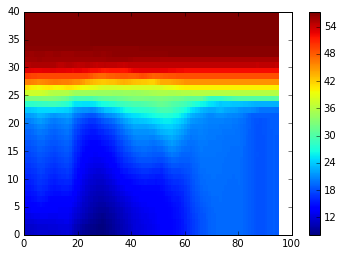

In [88]:
plt.pcolormesh(calculated['Si'][0, :, 0, :95])
plt.colorbar()